In [6]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns

In [744]:
indices = [
    "^GSPC",  # S&P 500 - Tracks 500 largest US companies
    "^DJI",   # Dow Jones Industrial Average - 30 large US blue-chip companies
    "^IXIC",  # NASDAQ Composite - Tech-heavy US stock market index
    "^BUK100P",  # Cboe UK 100 - 100 largest companies listed on London Stock Exchange
    "^RUT",   # Russell 2000 - 2000 small-cap US companies
    "^GDAXI", # DAX - 40 major German companies trading on Frankfurt Stock Exchange
    "^FCHI",  # CAC 40 - 40 most significant stocks on Euronext Paris
    "^N100",  # Euronext 100 Index - 100 largest Euronext companies
    "^BFX",   # BEL 20 - 20 most liquid Belgian companies
    "^HSI",   # HANG SENG INDEX - Major Hong Kong stock market index
    "^STI",   # STI Index - Benchmark index for Singapore stock market
    "^AXJO",  # S&P/ASX 200 - 200 largest Australian companies
    "^BSESN", # S&P BSE SENSEX - 30 largest Indian companies
    "^JKSE",  # IDX COMPOSITE - Indonesia Stock Exchange main index
    "^KLSE",  # FTSE Bursa Malaysia KLCI - Malaysian stock market index
    "^NZ50",  # S&P/NZX 50 - 50 largest New Zealand companies
    "^KS11",  # KOSPI - Korean stock market index
    "^TWII",  # TWSE - Taiwan Stock Exchange index
    "^GSPTSE",  # S&P/TSX Composite - Canadian stock market index
    "^BVSP",  # IBOVESPA - Brazilian stock market index
    "^MXX",   # IPC MEXICO - Mexican stock market index
    "^MERV",  # MERVAL - Argentine stock market index
    "^TA125.TA",  # TA-125 - Tel Aviv Stock Exchange index
    "^JN0U.JO",  # Top 40 USD Net TRI Index - South African stock market index
    "^125904-USD-STRD",  # MSCI EUROPE - European stock market index
    "000001.SS",  # SSE Composite Index - Shanghai Stock Exchange index
    "^N225"  # Nikkei 225 - Japanese stock market index
]
RFR = "^FVX" # Treasury Yield 5 Years

In [746]:
df =  yf.download(indices,period='1y',interval='1d')
rfr =  yf.download(RFR,period='1y',interval='1d')

[*********************100%***********************]  27 of 27 completed
[*********************100%***********************]  1 of 1 completed


In [784]:
price = df['Close']
log_return = np.log(price/price.shift()).fillna(0)

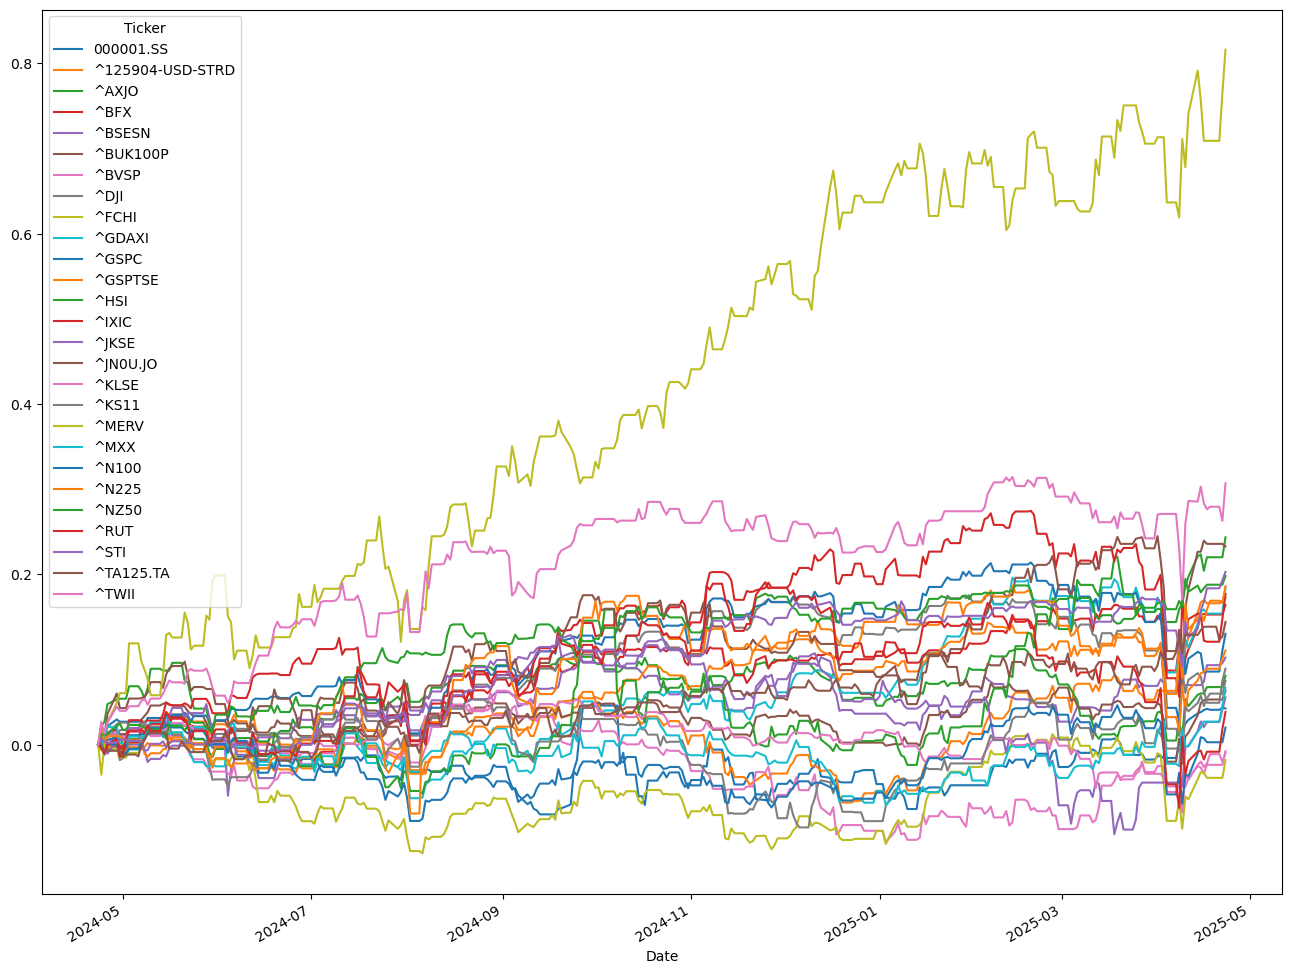

In [786]:
log_return.cumsum().plot(figsize=(16,13))
plt.show()

We use the correlation
$$
\rho_{i,j} = \frac{\mathrm{Cov}(r_i,r_j)}{\sigma_i \sigma_j}
$$
to calculate the hedging ratio
$$
\beta_{i,j} = \rho_{i,j} \frac{\sigma_i}{\sigma_j}
$$


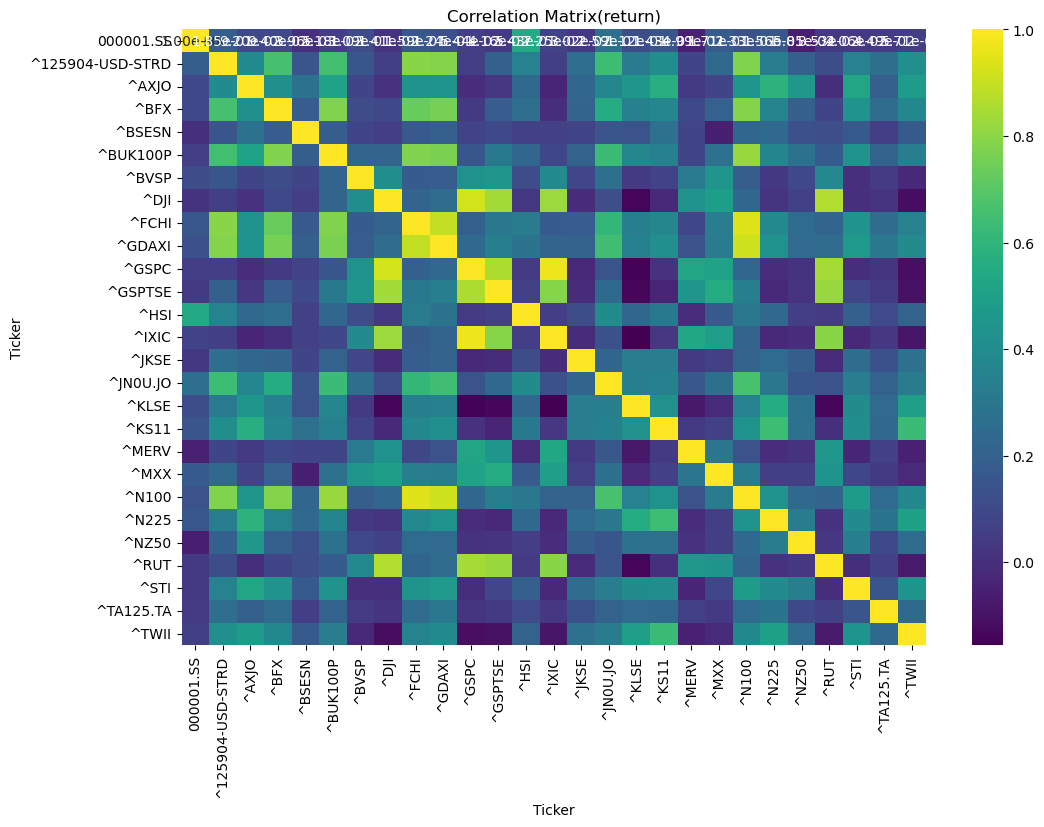

In [789]:
co_matrix = log_return.corr()   
co_matrix = co_matrix.fillna(0)  # Replace NaN with 0

plt.figure(figsize=(12, 8))
sns.heatmap(co_matrix, annot=True, cmap='viridis', fmt='.2e')
plt.title('Correlation Matrix(return)')
plt.show()

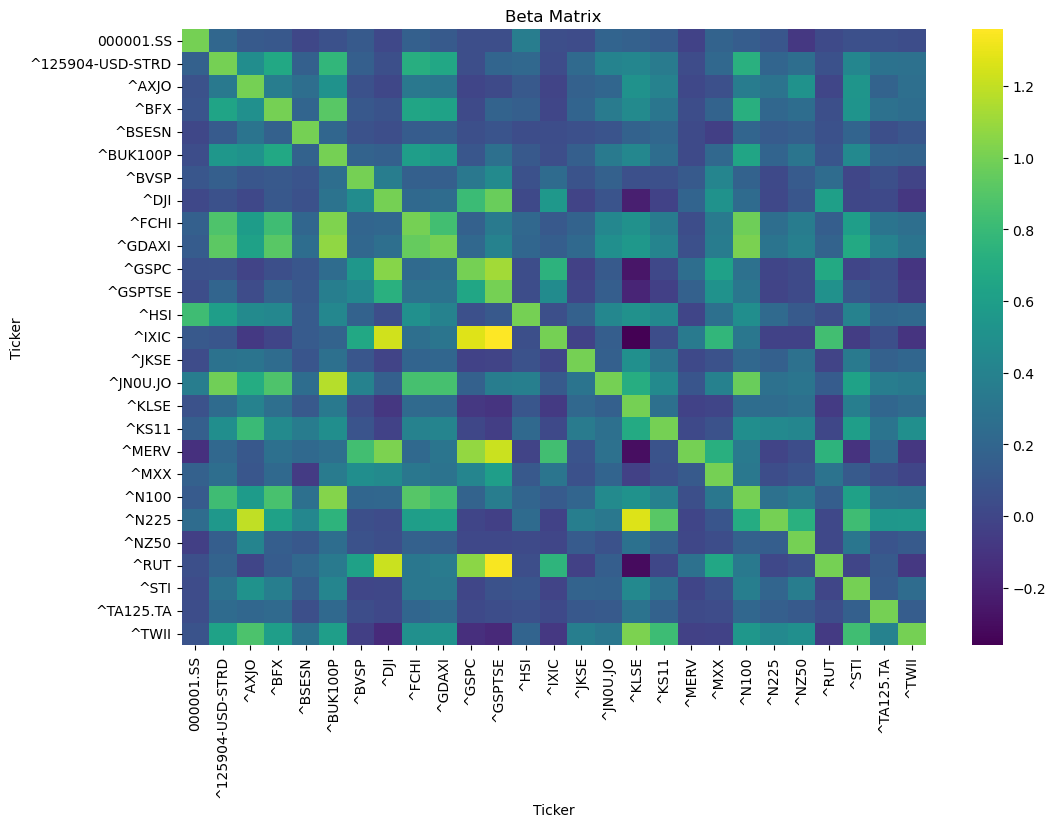

In [791]:
std_devs = log_return.std()
beta_matrix = pd.DataFrame(index=co_matrix.index, columns=co_matrix.columns)
for i in co_matrix.index:
    for j in co_matrix.columns:
        beta_matrix.loc[i, j] = co_matrix.loc[i, j] * (std_devs[i] / std_devs[j])
        
beta_matrix = beta_matrix.fillna(0)  # Replace NaN with 0

plt.figure(figsize=(12, 8))
sns.heatmap(beta_matrix, annot=False, cmap='viridis', fmt='.4e')
plt.title('Beta Matrix')
plt.show()

Simple portfolio weight

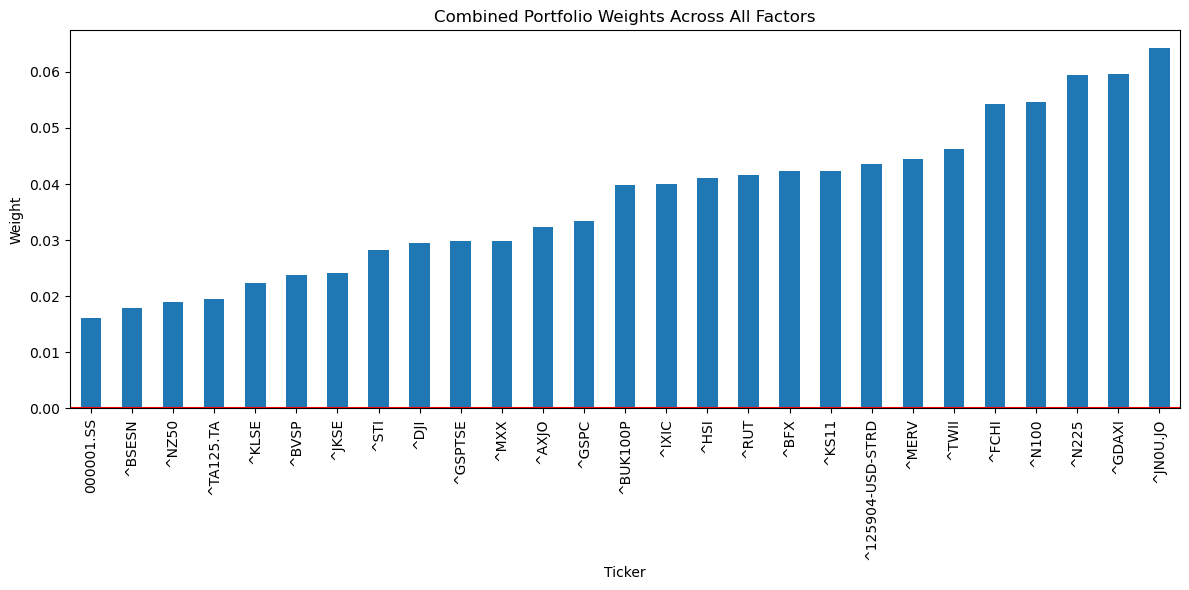

In [725]:
combined_betas = beta_matrix.sum(axis=1)
weights = combined_betas / combined_betas.abs().sum()
plt.figure(figsize=(12, 6))
weights.sort_values().plot(kind='bar')
plt.title('Combined Portfolio Weights Across All Factors')
plt.ylabel('Weight')
plt.axhline(y=0, color='r', linestyle='-')
plt.tight_layout()
plt.show()

In [727]:
def Weighted_cum_return(LR, W):
    WLR = pd.DataFrame(index=LR.index)
    for date in LR.index:
        WLR.loc[date, 'Log return'] = sum(LR.loc[date] * W)
    WLR = WLR.cumsum()
    return WLR

In [729]:
equal_weight = pd.Series(np.ones(len(log_return.columns))/len(log_return.columns), index=log_return.columns)
banchmark = np.exp(Weighted_cum_return(log_return, equal_weight))

Portfolio = np.exp(Weighted_cum_return(log_return, weights))

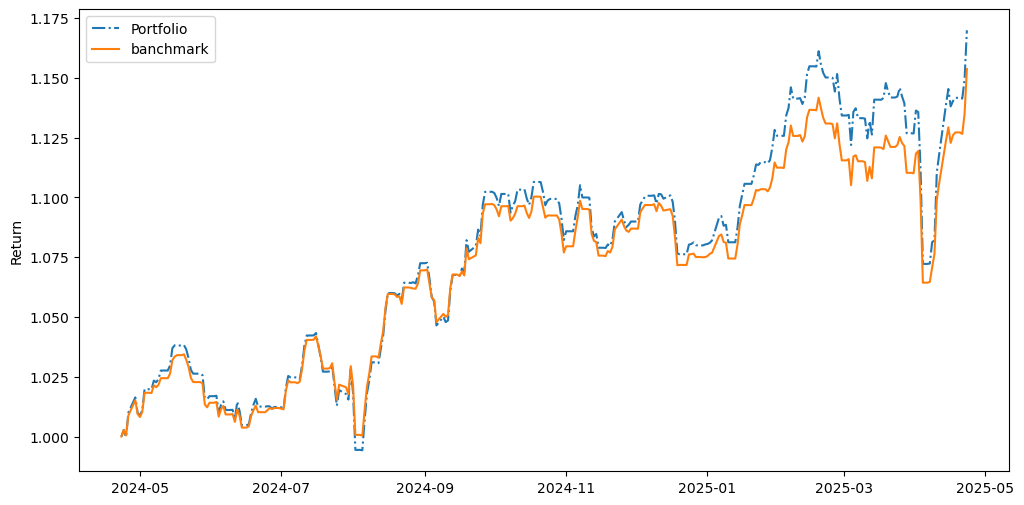

In [731]:
plt.figure(figsize=(12,6))
plt.plot(Portfolio,label='Portfolio',linestyle='-.')
plt.plot(banchmark,label='banchmark')
plt.ylabel('Return')
plt.legend()
plt.show()

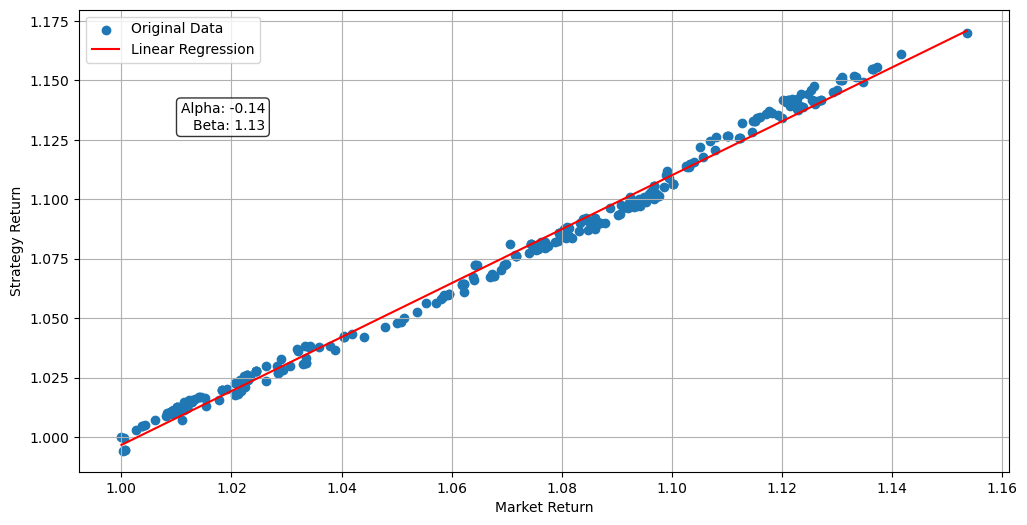

In [733]:
import Functions.AlphaBeta as MT
plt.figure(figsize=(12,6))
alpha, beta = MT.AlphaBeta(Portfolio.values.reshape(-1), banchmark.values.reshape(-1), plot=True)

In [735]:
print(f"alpha: {alpha}, beta: {beta}")

alpha: -0.137, beta: 1.134


So we just need to short the portfolio and long the benchmark.

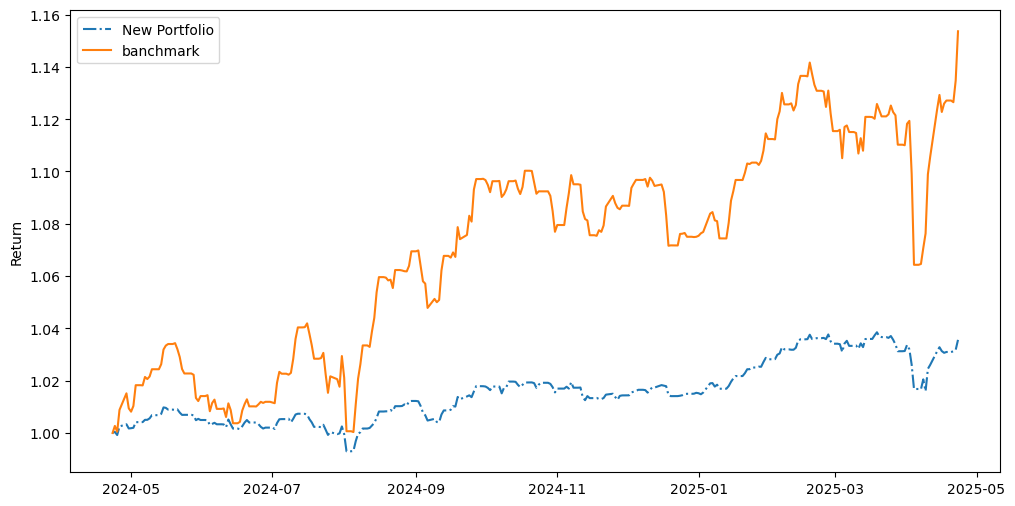

In [738]:
new_weight = (beta*weights - equal_weight)
New_Portfolio = np.exp(Weighted_cum_return(log_return, new_weight))
plt.figure(figsize=(12,6))
plt.plot(New_Portfolio,label='New Portfolio',linestyle='-.')
plt.plot(banchmark,label='banchmark')
plt.ylabel('Return')
plt.legend()
plt.show()

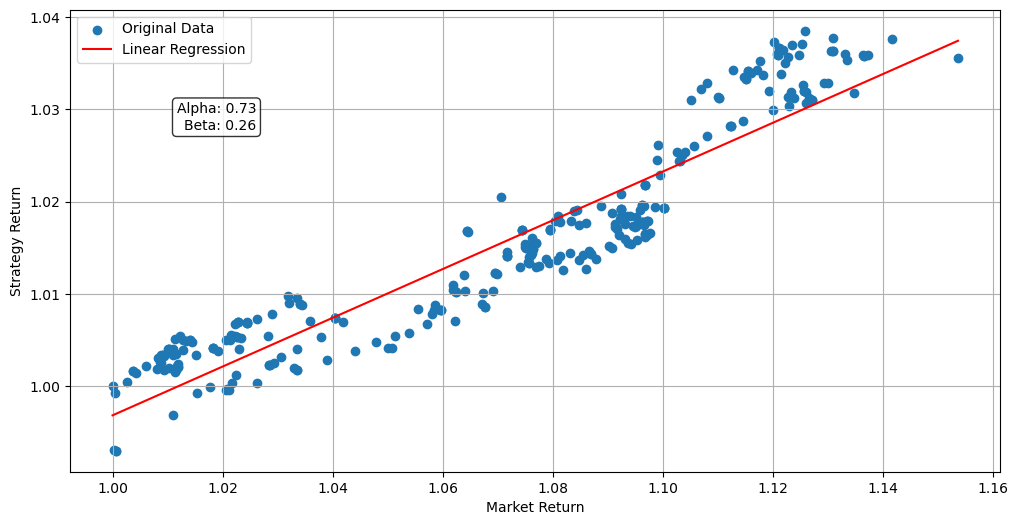

In [740]:
plt.figure(figsize=(12,6))
New_alpha, New_beta = MT.AlphaBeta(New_Portfolio.values.reshape(-1), banchmark.values.reshape(-1), plot=True)